In [1]:
# Further analysis on filtered_email_no_vendors and public_domain_df to identify the true positive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer 
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score ,confusion_matrix, \
ConfusionMatrixDisplay,roc_auc_score, precision_recall_curve ,roc_auc_score
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier


In [2]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if pd.isnull(text):  # Handle missing values
        return ""
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())  # Remove special characters and numbers
    words = word_tokenize(text)  # Tokenize text
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords.words('english')]  # Remove stopwords and lemmatize
    return " ".join(words)

In [3]:
combined_data = pd.read_pickle('../data/combined_data.pkl')
#combined_data = pd.read_pickle('../data/final_balanced_data.pkl')

In [4]:
# Apply the function to the email content
combined_data['cleaned_email'] = combined_data['content'].map(preprocess_text)

In [5]:
# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores
combined_data['sentiment_score'] = combined_data['cleaned_email'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [6]:
# Sensitive keywords list
sensitive_keywords = [
    # General sensitive terms
    'password', 'confidential', 'secret', 'token', 'login', 'access',
    'invoice', 'payment', 'tax', 'contract', 'NDA', 'urgent', 'credentials',
    'restricted', 'classified', 'proprietary', 'secure', 'encrypted',
    
    # Phishing and malicious intent
    'link', 'click', 'phishing', 'malware', 'attachment', 'download', 'verify', 'authentication', 'reset',
    'security breach', 'unauthorized', 'exposure', 'compromise', 'hack', 'exploit',

    # Personal information
    'SSN', 'ID number', 'passport', 'driver’s license', 'address', 'bank account', 'credit card', 
    'personal', 'medical', 'insurance', 'privacy',

    # Technical terms
    'blueprint', 'source code', 'repository', 'algorithm', 'intellectual property', 'prototype', 'specification',
    'server', 'database', 'API', 'framework', 'architecture', 'pipeline',

    # Urgent or secretive phrases
    'private', 'delete this', 'keep this secret', 'burn after reading', 'for your eyes only', 
    'do not share', 'immediate attention', 'asap', 'strictly confidential',

    # Financial and operational terms
    'wire transfer', 'invoice', 'ledger', 'audit', 'compliance', 'budget', 'expense', 'profit', 
    'margin', 'forecast', 'valuation', 'merger', 'acquisition',

    # Industry-specific terms (customize as needed)
    'trade secret','contract negotiation', 'strategic plan', 'market analysis', 

    # Additional potential triggers
    'fraud', 'scam', 'deceptive', 'embezzlement', 'money laundering', 'corruption'
]

def detect_keywords(content):
    return any(keyword in content for keyword in sensitive_keywords)

#keyword-based threat detection
combined_data['keyword_threat'] = combined_data['cleaned_email'].apply(detect_keywords)


In [7]:
combined_data['keyword_threat'].value_counts()
#About 18% of the dataset was flagged as containing potential threats based on the keyword list.

keyword_threat
False    12853
True      2651
Name: count, dtype: int64

In [8]:
# Anomaly detection: High positive sentiment or sensitive keywords to get the higher data 
combined_data['anomaly'] = (combined_data['sentiment_score'] > 0.8) | combined_data['keyword_threat']

# Investigate anomalies
anomalous_emails = combined_data[combined_data['anomaly']]

# Output the anomalous emails
# print("Anomalous Emails:")
# print(anomalous_emails[['cleaned_email','sentiment_score','keyword_threat','anomaly']])

In [9]:
combined_data['anomaly'].value_counts()

anomaly
False    10638
True      4866
Name: count, dtype: int64

## Content Analyst using NPL

In [11]:
combined_data.columns

Index(['user', 'content', 'num_recipients', 'hour', 'day_of_week',
       'attachments', 'size', 'threat_flag', 'cleaned_email',
       'sentiment_score', 'keyword_threat', 'anomaly'],
      dtype='object')

In [12]:
#Target
y = combined_data['threat_flag']

In [13]:
combined_data

,user,content,num_recipients,hour,day_of_week,attachments,size,threat_flag,cleaned_email,sentiment_score,keyword_threat,anomaly
0,ABC0174,gold negotiating 13 vice entry coach memorial ...,1,14,5,0,19677,True,gold negotiating vice entry coach memorial mid...,0.7096,False,False
1,ABC0174,future always planets poorer jupiters only soo...,3,14,5,0,23739,True,future always planet poorer jupiter soon specu...,-0.6249,True,True
2,ABC0174,100 bruins eight 1997 intensive fan reprimande...,1,14,5,0,25277,True,bruin eight intensive fan reprimanded corey mv...,0.8402,False,True
3,ABC0174,nhls 01 season teammate home minnesota win str...,2,14,5,0,40514,True,nhls season teammate home minnesota win streng...,0.8271,False,True
4,ABC0174,naturally formed nuclei rising hours york expe...,4,14,5,0,20614,True,naturally formed nucleus rising hour york expe...,-0.0258,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
15499,RVC0232,substantial last not not 120 received recover ...,2,17,0,0,76284,False,substantial last received recover enacted scal...,0.4939,False,False
15500,KAT0489,20 horizontally morning left inversion radiate...,4,17,0,2,21608,False,horizontally morning left inversion radiated l...,0.5677,False,False
15501,RGN0408,led regarded personal low man smashing lot par...,2,17,0,1,27696,False,led regarded personal low man smashing lot par...,-0.5574,True,True
15502,MAE0331,have ukraine be pron money terminally more fre...,2,17,0,0,32210,False,ukraine pron money terminally fresh father goo...,0.7269,False,False


In [14]:
# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the data ()
X = vectorizer.fit_transform(combined_data['cleaned_email'])

In [15]:
# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(class_weight='balanced', random_state=42,max_iter=500)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5856175427281523
Classification Report:
               precision    recall  f1-score   support

       False       0.70      0.66      0.68      2051
        True       0.40      0.44      0.42      1050

    accuracy                           0.59      3101
   macro avg       0.55      0.55      0.55      3101
weighted avg       0.60      0.59      0.59      3101



In [16]:
param_grid = {
    'C': [0.1],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced', None],
    'max_iter': [4000]
}

grid = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='f1_macro')
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
model = grid.best_estimator_

y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 4000, 'solver': 'saga'}
Accuracy: 0.5869074492099323
Classification Report:
               precision    recall  f1-score   support

       False       0.70      0.66      0.68      2051
        True       0.40      0.45      0.43      1050

    accuracy                           0.59      3101
   macro avg       0.55      0.55      0.55      3101
weighted avg       0.60      0.59      0.59      3101



In [17]:
# Extracting best parameters from grid search
best_params = grid.best_params_
print("Best Parameters from Logistic Regression GridSearchCV:", best_params)

# Adjusted class weights based on logistic regression
pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# XGBoost model with additional hyperparameters tuned
xgb_model = XGBClassifier(
    scale_pos_weight=pos_weight,
    random_state=42,
    learning_rate=0.1,  # Example learning rate
    max_depth=6,  # Example max depth
    n_estimators=100,  # Example n_estimators
    objective='binary:logistic',  # Ensure binary classification objective
    eval_metric='logloss'  # Set evaluation metric for better optimization
)

xgb_model.fit(X_train, y_train)

# Predict probabilities and apply a threshold for classification
y_prob = xgb_model.predict_proba(X_test)[:, 1]
threshold = 0.3  
y_pred = (y_prob > threshold).astype(int)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


Best Parameters from Logistic Regression GridSearchCV: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 4000, 'solver': 'saga'}
Accuracy: 0.344727507255724
Classification Report:
               precision    recall  f1-score   support

       False       0.85      0.01      0.02      2051
        True       0.34      1.00      0.51      1050

    accuracy                           0.34      3101
   macro avg       0.60      0.50      0.26      3101
weighted avg       0.68      0.34      0.19      3101

ROC AUC Score: 0.5651974646513895


In [18]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model.fit(X_train_resampled, y_train_resampled)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6091583360206385
Classification Report:
               precision    recall  f1-score   support

       False       0.69      0.75      0.72      2051
        True       0.41      0.34      0.37      1050

    accuracy                           0.61      3101
   macro avg       0.55      0.54      0.54      3101
weighted avg       0.59      0.61      0.60      3101



In [40]:
# Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X = vectorizer.fit_transform(combined_data['cleaned_email'])

# Scaling (for sparse matrices, set with_mean=False)
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Logistic Regression GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced', None],
    'max_iter': [5000, 10000]  # Increase max_iter even further
}

grid = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='f1_macro')
grid.fit(X_resampled, y_resampled)

# Best Logistic Regression Model
lr_model = grid.best_estimator_

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# XGBoost Classifier
pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])  # Handle class imbalance
xgb_model = XGBClassifier(
    scale_pos_weight=pos_weight,
    random_state=42,
    learning_rate=0.05,
    max_depth=6,
    n_estimators=300,
    objective='binary:logistic',
    eval_metric='logloss'
)

# Fit the model
xgb_model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False  # Suppress logs for cleaner output
)

# Optimal Threshold for XGBoost
y_prob = xgb_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print("Optimal Threshold:", optimal_threshold)

# Predict with optimal threshold
y_pred = (y_prob > optimal_threshold).astype(int)

# Logistic Regression Evaluation
y_pred_lr = lr_model.predict(X_test)
print("\n=== Logistic Regression Evaluation ===")
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))
print("Logistic Regression Report:\n", confusion_matrix(y_test, y_pred_lr))

# Ensemble with VotingClassifier
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('xgb', xgb_model)
    ],
    voting='soft'  # Use soft voting for probabilities
)
ensemble_model.fit(X_resampled, y_resampled)
y_pred_ensemble = ensemble_model.predict(X_test)

print("\n=== Ensemble Evaluation ===")
print("Ensemble Accuracy:", accuracy_score(y_test, y_pred_ensemble))
print("Ensemble Classification Report:\n", classification_report(y_test, y_pred_ensemble))
print("Ensemble Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ensemble))

/var/folders/zy/rzr3n79j0mb4zk8gxww6xsd40000gn/T/ipykernel_77791/2989229928.py:53: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Optimal Threshold: 0.8239438

=== Logistic Regression Evaluation ===
Logistic Regression Accuracy: 0.801354401805869
Logistic Regression Report:
               precision    recall  f1-score   support

       False       0.84      0.86      0.85      2051
        True       0.72      0.69      0.70      1050

    accuracy                           0.80      3101
   macro avg       0.78      0.77      0.78      3101
weighted avg       0.80      0.80      0.80      3101

Logistic Regression Report:
 [[1764  287]
 [ 329  721]]

=== Ensemble Evaluation ===
Ensemble Accuracy: 0.8103837471783296
Ensemble Classification Report:
               precision    recall  f1-score   support

       False       0.86      0.86      0.86      2051
        True       0.72      0.72      0.72      1050

    accuracy                           0.81      3101
   macro avg       0.79      0.79      0.79      3101
weighted avg       0.81      0.81      0.81      3101

Ensemble Confusion Matrix:
 [[1756  295]
 [ 

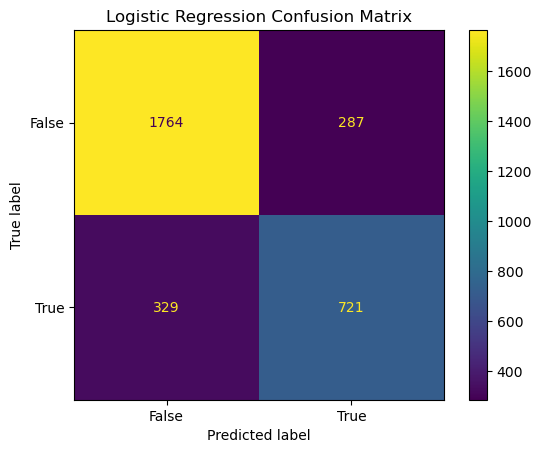

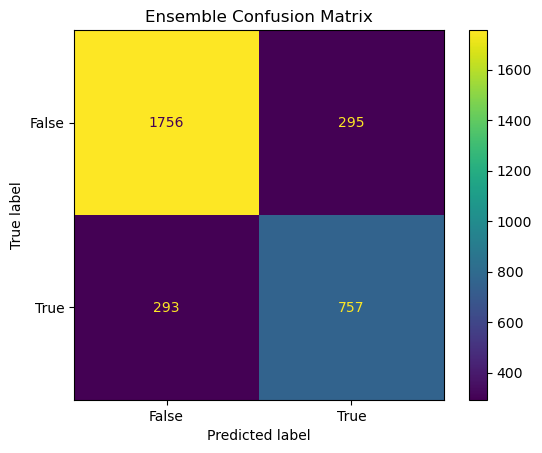

In [37]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, display_labels=['False', 'True'])
plt.title("Logistic Regression Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ensemble, display_labels=['False', 'True'])
plt.title("Ensemble Confusion Matrix")
plt.show()

## Feature select to idenfity threat

In [42]:
#Add other feature to identify possible threats
features = ['num_recipients', 'hour', 'day_of_week','attachments', 'size' \
                           ,'sentiment_score', 'keyword_threat','anomaly']
X_feature = combined_data[features]

In [44]:
# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_feature, y, test_size=0.2, random_state=42)


model = LogisticRegression(class_weight='balanced', random_state=42,solver='lbfgs', max_iter=4000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5172524991938084
Classification Report:
               precision    recall  f1-score   support

       False       0.68      0.50      0.58      2051
        True       0.36      0.55      0.43      1050

    accuracy                           0.52      3101
   macro avg       0.52      0.52      0.51      3101
weighted avg       0.57      0.52      0.53      3101



In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_rf, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=4,
    class_weight='balanced',  
    random_state=42
)
rf_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

Confusion Matrix:
[[1537  522]
 [ 699  343]]

Classification Report:
              precision    recall  f1-score   support

       False       0.69      0.75      0.72      2059
        True       0.40      0.33      0.36      1042

    accuracy                           0.61      3101
   macro avg       0.54      0.54      0.54      3101
weighted avg       0.59      0.61      0.60      3101


Accuracy Score: 0.6062560464366333


In [50]:
# Define the parameter grid for XGboost
param_grid = {
    'n_estimators': [50, 100, 200],      # Number of trees
    'max_depth': [4, 6, 8],             # Depth of each tree
    'learning_rate': [0.01, 0.1, 0.2],  # Step size for updates
    'subsample': [0.8, 1.0],            # Fraction of samples per tree
    'colsample_bytree': [0.8, 1.0],     # Fraction of features per tree
    'scale_pos_weight': [1, pos_weight] # Adjusting class imbalance
}

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc', # Evaluating using AUC-ROC
    cv=5,              # 5-fold cross-validation
    verbose=1,
    n_jobs=-1          # Use all available processors
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'scale_pos_weight': 1, 'subsample': 1.0}
Best ROC AUC Score: 0.5931618878544764


In [92]:
best_params = grid_search.best_params_
xgb_best_model = XGBClassifier(**best_params, random_state=42)
xgb_best_model.fit(X_train, y_train)
new_threshold = 0.32

# Evaluate
y_prob = xgb_best_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob > new_threshold).astype(int)  

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
[[1062  989]
 [ 444  606]]

Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.52      0.60      2051
        True       0.38      0.58      0.46      1050

    accuracy                           0.54      3101
   macro avg       0.54      0.55      0.53      3101
weighted avg       0.60      0.54      0.55      3101


ROC AUC Score: 0.5743711546051868


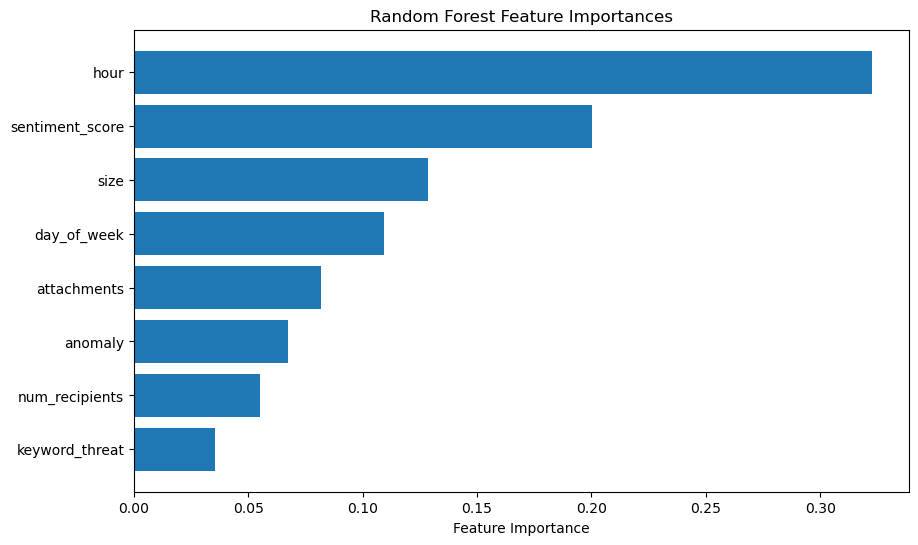

In [56]:
# Get feature importances
feature_importances = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importances)[::-1]
sorted_features = [features[i] for i in sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_features)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')
plt.show()


In [76]:
sorted_features

['hour',
 'sentiment_score',
 'size',
 'day_of_week',
 'attachments',
 'anomaly',
 'num_recipients',
 'keyword_threat']